In [4]:
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point, Polygon
from transformers import DistilBertTokenizerFast
import matplotlib.pyplot as plt
import geopandas
# from sklearn.cluster import DBSCAN
import pandas as pd
import torch
import numpy as np
from scipy.spatial import ConvexHull
from api.model import GeoModel

In [5]:
BASE_MODEL = 'models/2021-12-03_model-distilbert-base-uncased_loss-wiki_exploded_geonames'
TOKEN_MODEL = 'distilbert-base-uncased'

In [6]:
geobert = GeoModel(
    model_string=BASE_MODEL,
    tokenizer_string=TOKEN_MODEL,
    tokenizer_class=DistilBertTokenizerFast,
    max_seq_length=200)

In [7]:
text = '''
Olaf Scholz was voted in as Germany's new Chancellor on Wednesday, bringing to an end Angela Merkel's four terms at the helm of Europe's largest economy.

Scholz, the leader of the Social Democratic Party (SPD), won the secret vote in the Parliament as expected, a culmination of months of negotiations following the SPD's narrow victory in September's federal elections.
Following the ceremonial protocols, Scholz went to see German President Frank-Walter Steinmeier who officially appointed him as the country's new Chancellor. He will be sworn in at the Parliament later on Wednesday.
The 63-year-old life-long member of the SPD served as the Labor and Social Affairs minister in Merkel's first coalition government in the late 2000s. In 2011 he was elected mayor of Hamburg, a position he held -- with high levels of support -- until 2018.
Since then, he has served as the vice-chancellor and finance minister in Merkel's grand coalition government, a powerful position in German national politics.
His political style is not dissimilar to that of his former boss -- the two are alike in many ways, despite hailing from rival parties.
'''


In [8]:
geobert.forward(text=text)
out = geobert.predict_point()
out

array([52.113876, 11.087173], dtype=float32)

In [9]:
last_hidden_state = geobert.output['hidden_states'][-1]
hidden_state = last_hidden_state  # (bs, seq_len, dim)
pooled_output = hidden_state[:, 0]  # (bs, dim)
rand_locs = []
pooled_output_dim = pooled_output.shape[1]
with torch.no_grad():
    geobert.model.eval()
    for i in range(pooled_output_dim):
        ones = torch.ones_like(pooled_output)
        dim1 = ones.shape[1]
        rand_dim1 = np.random.randint(0, dim1)
        ones[0, rand_dim1] = 0
        masked_output = ones * pooled_output
        pre_clf_output = geobert.model.pre_classifier(masked_output)  # (bs, dim)
        relu_output = torch.nn.ReLU()(pre_clf_output)  # (bs, dim)
        rand_loc = geobert.model.classifier(relu_output).cpu().detach().numpy().squeeze()
        rand_locs.append(rand_loc)

out_df = pd.DataFrame(rand_locs, columns=['lat', 'lon'])

In [10]:
kde = KernelDensity(
    kernel='gaussian',
    metric='haversine',
    bandwidth=10)

In [8]:
# out_df *= np.pi / 180

In [37]:
kde.fit(np.radians(out_df))

KernelDensity(bandwidth=10, metric='haversine')

In [38]:
# lat_mean = conf_df['lat'].mean()
# lon_mean = conf_df['lon'].mean()

In [39]:
lat_space = np.linspace(-np.pi/2, np.pi/2, 100)
lon_space = np.linspace(-np.pi, np.pi, 100)
# lat_space = np.linspace(-90 , 90, 100)
# lon_space = np.linspace(-180, 180, 100)
X, Y = np.meshgrid(lon_space, lat_space)
xy = np.vstack([X.ravel(), Y.ravel()]).T
X, Y = np.rad2deg(X), np.rad2deg(Y)
Z = kde.score_samples(xy)
Z = Z.reshape(X.shape)

In [40]:
# world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

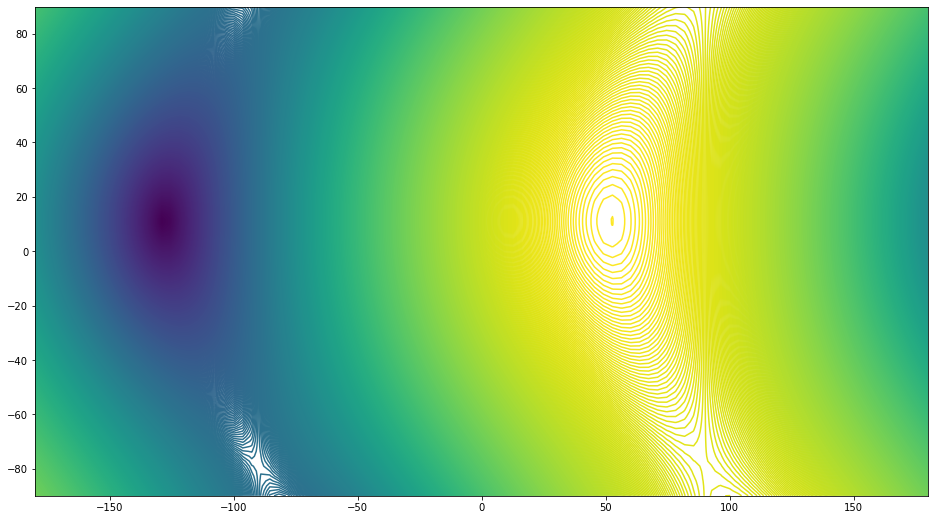

In [41]:
plt.figure(figsize=(16,9))
cont = plt.contour(X, Y, Z, 1000)
# world.plot(color="lightgrey")

In [33]:
cont.allsegs[-2]

[array([[52.72727273,  9.38697618],
        [52.90960347, 10.        ],
        [52.95472377, 11.81818182],
        [52.72727273, 12.73796577],
        [52.23503082, 11.81818182],
        [52.3339617 , 10.        ],
        [52.72727273,  9.38697618]])]

In [61]:
conf_sample = np.rad2deg(kde.sample(1000))
conf_sample = np.fmod(conf_sample, [90, 180])
conf_probas = np.exp(kde.score_samples(conf_sample))
conf_probas /= conf_probas.sum()
conf_df = pd.Series(conf_probas, name='proba').to_frame()

In [62]:
conf_sample
conf_df['point'] = geopandas.GeoSeries([Point(point[::-1]) for point in conf_sample])
conf_df.loc[:,['lat', 'lon']] = conf_sample

In [63]:
conf_df['cdf'] = conf_df.sort_values('proba', ascending=False).proba.cumsum()

In [64]:
levels = 10

In [65]:
conf_df['conf_level'] = pd.qcut(conf_df.cdf, q=levels, labels=False)

In [66]:
conf_areas = []
for level in range(levels):
    conf_area_points = conf_df[conf_df.conf_level == level][['lat', 'lon']]
    conf_area_hull = ConvexHull(conf_area_points.values)
    vertecies = conf_area_hull.points[conf_area_hull.vertices]
    points = geopandas.GeoSeries([Point(point[::-1]) for point in vertecies])
    polygon = Polygon(points)
    conf_areas.append(polygon)

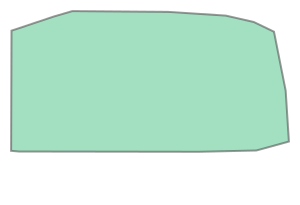

In [67]:
conf_areas[0]

In [68]:
conf_area_series = geopandas.GeoSeries(conf_areas)

In [69]:
conf_area_series

0    POLYGON ((63.40004 -87.53079, -163.42530 -87.1...
1    POLYGON ((-153.60795 -72.40600, -171.12232 39....
2    POLYGON ((84.59987 89.41382, 164.96669 69.7028...
3    POLYGON ((-0.00991 -88.20764, -124.30599 -87.6...
4    POLYGON ((-176.61081 -63.18582, -165.83415 88....
5    POLYGON ((145.49975 -85.15094, 74.60853 -85.20...
6    POLYGON ((177.37912 -76.07155, 94.57412 -89.18...
7    POLYGON ((-82.78503 85.64078, 179.87004 79.895...
8    POLYGON ((157.23103 -84.65342, -23.40592 -89.1...
9    POLYGON ((148.85721 -89.12481, -81.53135 -89.9...
dtype: geometry

In [70]:
import folium
from folium.plugins import HeatMap

In [71]:
maploc = folium.Map(
#     location=[conf_df.lon.mean(), conf_df.lat.mean()],
    zoom_start=11,
    tiles="Stamen Toner", 
    # min_lat=conf_df['point'].map(lambda x: x.x).min(), 
    # max_lat=conf_df['point'].map(lambda x: x.x).max(),
    # min_lon=conf_df['point'].map(lambda x: x.y).min(),
    # max_lon=conf_df['point'].map(lambda x: x.y).max()
)
maploc.add_child(folium.GeoJson(
    data=conf_area_series.to_json(), 
    style_function=lambda x: {'fillColor': 'blue', 'stroke': False, 'fillOpacity': 0.1})
)
# maploc.add_child(HeatMap(out_df))
maploc.add_child(HeatMap(conf_sample))
maploc